In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import autograd
import torch.autograd.functional as F

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
import json
import argparse
from types import SimpleNamespace

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
%run wrapper.ipynb

In [4]:
with open("config_model.json") as json_data:
    data = json.load(json_data, object_hook=lambda d: SimpleNamespace(**d))
    parameters_lstm = data.LSTM
    parameters_bilstm = data.BiLSTM
    parameters_seq2seq = data.Seq2Seq

In [5]:
# def plot_full_dataset(real_dataset, gen_dataset, startindex, endindex, col, model):
#     tr = real_dataset[startindex:endindex, col]
#     te = gen_dataset[startindex:endindex, col]
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(model + ' prediction on test dataset')
#     plt.ylabel('Energy Consumption in Kwh')
#     plt.plot(tr, label='Actual')
#     plt.plot(te, label='Predicted')
#     plt.legend()
#     plt.show()

def plot_full_dataset(real_dataset, gen_dataset, timestamps, startindex, endindex, col, model):
    tr = real_dataset[startindex:endindex, col]
    te = gen_dataset[startindex:endindex, col]
    ts = timestamps[startindex:endindex]

    plt.figure(figsize=(20, 6))
    plt.suptitle(model + ' prediction on test dataset')
    plt.xlabel('Timestamp')
    plt.ylabel('Energy Consumption in Kwh')
    plt.plot(ts, tr, label='Actual')
    plt.plot(ts, te, label='Predicted')
    plt.legend()
    plt.show()

In [6]:
# def compare_predicted_dataset(real_dataset, gen_dataset_lstm, gen_dataset_bilstm, gen_dataset_seq, startindex, endindex, col):
#     tr = real_dataset[startindex:endindex, col]
#     te1 = gen_dataset_lstm[startindex:endindex, col]
#     te2 = gen_dataset_bilstm[startindex:endindex, col]
#     te3 = gen_dataset_seq[startindex:endindex, col]
#     plt.figure(figsize=(20, 10))
#     plt.suptitle('Prediction on test dataset')
#     plt.ylabel('Energy Consumption in Kwh')
#     plt.plot(tr, label='True value', linewidth=3)
#     plt.plot(te1, label='Lstm', linewidth=2)
#     plt.plot(te2, label='Bilstm', linewidth=2)
#     plt.plot(te3, label='Seq2seq', linewidth=2)
#     plt.legend()
#     plt.show()

def compare_predicted_dataset(real_dataset, gen_dataset_lstm, gen_dataset_bilstm, gen_dataset_seq, timestamps, startindex, endindex, col):
    tr = real_dataset[startindex:endindex, col]
    te1 = gen_dataset_lstm[startindex:endindex, col]
    te2 = gen_dataset_bilstm[startindex:endindex, col]
    te3 = gen_dataset_seq[startindex:endindex, col]
    ts = timestamps[startindex:endindex]

    plt.figure(figsize=(20, 10))
    plt.suptitle('Prediction on test dataset')
    plt.xlabel('Timestamp')
    plt.ylabel('Energy Consumption in Kwh')
    plt.plot(ts, tr, label='True value', linewidth=3)
    plt.plot(ts, te1, label='LSTM', linewidth=2)
    plt.plot(ts, te2, label='BiLSTM', linewidth=2)
    plt.plot(ts, te3, label='Seq2Seq', linewidth=2)
    plt.legend()
    plt.show()

In [7]:
#  L  S  T  M    M  O  D  E  L

class vanilla_LSTM(nn.Module):
    def __init__(self, model_parameter):
        super(vanilla_LSTM, self).__init__()
        self.input_size = model_parameter.input_size
        self.hidden_size = model_parameter.hidden_size
        self.output_size = model_parameter.output_size
        self.future_step = model_parameter.future_step
        self.batch_size = model_parameter.batch_size
        self.lag_window = model_parameter.lag_window

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size * self.lag_window, self.future_step * self.output_size)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        lstm, (_,_) = self.lstm(x)
        lstm, (_,_) = self.lstm2(lstm)
        lstm = self.flatten(lstm)
        final = self.linear(lstm)
        final = final.view(self.batch_size, self.future_step, -1)
        return self.relu(final)

In [8]:
#  B i  L  S  T  M    M  O  D  E  L

class Bi_LSTM(nn.Module):
    def __init__(self, model_parameter):
        super(Bi_LSTM, self).__init__()
        self.input_size = model_parameter.input_size
        self.hidden_size = model_parameter.hidden_size
        self.output_size = model_parameter.output_size
        self.future_step = model_parameter.future_step
        self.batch_size = model_parameter.batch_size
        self.lag_window = model_parameter.lag_window

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size= 2 * self.hidden_size, hidden_size=self.hidden_size, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * self.hidden_size * self.lag_window, self.future_step * self.output_size)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        lstm, (_,_) = self.lstm(x)
        #lstm, (_,_) = self.lstm2(lstm)
        lstm = self.flatten(lstm)
        final = self.linear(lstm)
        final = final.view(self.batch_size, self.future_step, -1)
        return self.relu(final)

In [9]:
# S  E  Q .2. S  E  Q    M  O  D  E  L

class Seq2SeqConv1D(nn.Module):
    def __init__(self, model_parameter):
        super(Seq2SeqConv1D, self).__init__()
        self.future_step = model_parameter.future_step
        self.output_size = model_parameter.output_size
        self.lag_window = model_parameter.lag_window
        self.num_blocks = model_parameter.num_blocks
        self.batch_size = model_parameter.batch_size
 
        self.resnet = nn.ModuleList([ResNetBlock(model_parameter) for _ in range(self.num_blocks)])
        
        self.linear = nn.Linear(self.output_size * self.lag_window, self.future_step * self.output_size)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        for block in self.resnet:
            x = block(x)
            
        x = self.flatten(x)
        x = self.linear(x)
        x = x.view(self.batch_size, self.future_step, -1)
        return self.activation(x)

class ResNetBlock(nn.Module):
    def __init__(self, model_parameter, padding=1):
        super(ResNetBlock, self).__init__()
        self.model_parameter = model_parameter
        self.input_size = model_parameter.input_size
        self.hidden_size = model_parameter.hidden_size
        self.output_size = model_parameter.output_size
        self.kernel_size = model_parameter.kernel_size
        self.future_step = model_parameter.future_step
        self.lag_window = model_parameter.lag_window
        self.batch_size = model_parameter.batch_size
    
        self.encoder_lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, batch_first=True, bidirectional=True)
        self.batchNorm1 = nn.BatchNorm1d(2 * self.hidden_size)

        self.encoder_conv1 = nn.Conv1d(in_channels=self.input_size, out_channels=self.hidden_size, kernel_size=self.kernel_size, padding=1)
        self.batchNorm2 = nn.BatchNorm1d(self.hidden_size)
        
        self.encoder_conv2 = nn.Conv1d(in_channels=self.hidden_size * 2, out_channels=self.hidden_size, kernel_size=self.kernel_size, padding=1)
        self.batchNorm3 = nn.BatchNorm1d(self.hidden_size)
        
        self.decoder_lstm = nn.LSTM(input_size=self.hidden_size * 3, hidden_size=self.hidden_size, batch_first=True, bidirectional=True)
        self.batchNorm4 = nn.BatchNorm1d(self.hidden_size)

        self.decoder_conv2 = nn.Conv1d(in_channels=self.hidden_size * 3, out_channels=self.hidden_size, kernel_size=self.kernel_size, padding=1)
        self.batchNorm5 = nn.BatchNorm1d(self.hidden_size)

        self.decoder_linear = nn.Linear(self.hidden_size * 2, self.hidden_size * 4)
        self.decoder_linear2 = nn.Linear(3 * self.hidden_size * self.lag_window, self.lag_window * self.output_size)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

    def forward(self, x):

        res = x
        #LSTM
        lstm, (_,_) = self.encoder_lstm(x)
        lstm = self.dropout(lstm)

        #CNN
        conv_input = torch.transpose(x, 1, 2)
        encoded = self.encoder_conv1(conv_input)
        encoded = self.batchNorm2(encoded)
        
        # encoded = self.encoder_conv2(encoded)
        # encoded = self.batchNorm3(encoded)
        #decoded = self.activation(decoded)
        decoded = torch.transpose(encoded, 1, 2)

        lstm = torch.cat((lstm, decoded), -1)
        #lstm = self.dropout(lstm)
        
        #LSTM
        #final, _ = self.decoder_lstm(lstm)
        #final = self.dropout(final)

        #final = self.decoder_linear(final)
        final = self.flatten(lstm)
        final = self.decoder_linear2(final)
        final = final.view(self.batch_size, self.lag_window, -1)

        final += res
        
        return self.activation(final)

In [10]:
columns = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum']

df = pd.read_csv("palo_alto_data_with_zero.csv")
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)

In [11]:
df.head()

,Day of week,Energy,Week Day,Year,Month,Day of month,Hour,Sum
0,5,2.356218,1,2011,7,29,20,2.356218
1,5,3.287746,1,2011,7,29,21,5.643964
2,5,0.605493,1,2011,7,29,22,6.249457
3,5,0.000000,1,2011,7,29,23,6.249457
4,6,0.106588,0,2011,7,30,0,0.106588


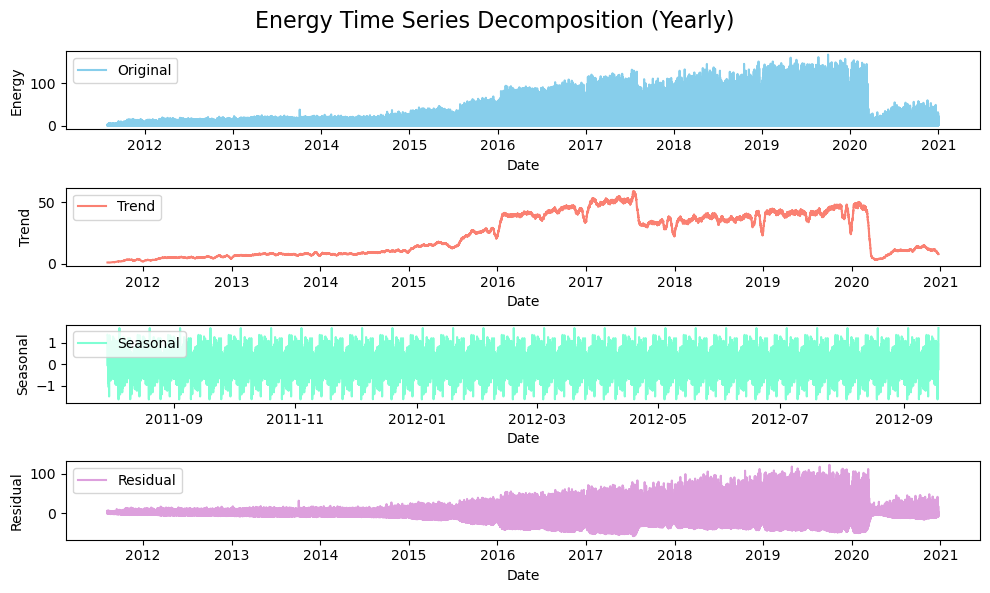

In [12]:
data = pd.read_csv("palo_alto_data_with_zero.csv", parse_dates=['Start'], index_col='Start')

# Select the 'Energy' column
energy_series = data['Energy']

# Perform time series decomposition
decomposition = seasonal_decompose(energy_series, model='additive', period=365)  # Assuming yearly seasonality

# Plot the decomposition
plt.figure(figsize=(10, 6))

plt.subplot(411)
plt.plot(energy_series, label='Original', color='skyblue')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Energy')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='salmon')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal[:10000], label='Seasonal', color='aquamarine')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='plum')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Residual')

plt.suptitle('Energy Time Series Decomposition (Yearly)', fontsize=16)
plt.tight_layout()
plt.show()

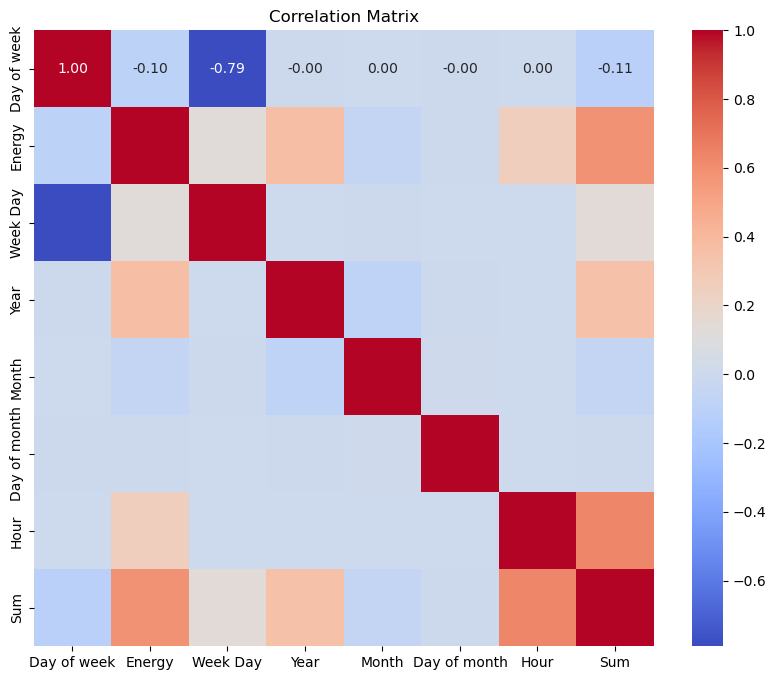

In [13]:
correlation_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [14]:
with open("config_model.json") as json_data:
    data = json.load(json_data, object_hook=lambda d: SimpleNamespace(**d))
    parameters_lstm = data.LSTM
    parameters_bilstm = data.BiLSTM
    parameters_seq2seq = data.Seq2Seq

In [15]:
class PrepareDataForInput():
    def __init__(self, model_parameter):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_parameter = model_parameter
    
    def filter_data_by_lag_size(self, dataset, lag):
        X_purified = []
        for i in range(len(dataset)):
            if (len(dataset[i]) == lag):
                X_purified.append(dataset[i])
        return X_purified
    
    def input_transform(self, real, lag, future_step = 0):
        X_real = []
        for i in range(len(real) - lag - future_step):
            lag_data = []
            for j in range(i, i+lag):
                lag_data.append(real[j])
            X_real.append(lag_data)
                
        X_real = np.stack(self.filter_data_by_lag_size(X_real, lag))

        return X_real
    
    def train_test_split(self, X, train_ratio):
        X_train = X[0: int(len(X) * train_ratio)]
        X_test = X[int(len(X) * train_ratio): len(X)]

        return X_train, X_test
    
    def get_forecasting_ground_truth_data(self, load, window, num):
        train_label = []

        for i in range(0, len(load) - window - num):
            lag_data = []
            for j in range(i + window, i + window + num):
                lag_data.append(load[j])
            train_label.append(lag_data)
        train_label = np.stack(train_label)
        return train_label
    
    def get_train_test_dataset_forecasting(self, df, train_test_ratio):
        real = df
        data = self.input_transform(real, self.model_parameter.lag_window, self.model_parameter.future_step)
        ground_truth = self.get_forecasting_ground_truth_data(real, self.model_parameter.lag_window, self.model_parameter.future_step)
        data_train, data_test = self.train_test_split(data, train_test_ratio)
        ground_truth_train, ground_truth_test = self.train_test_split(ground_truth, train_test_ratio)

        return data_train, data_test, ground_truth_train, ground_truth_test

In [16]:
class GetPcaTransformedData():
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def transform_data(self, df, columns):
        scaler = MinMaxScaler(feature_range=(0,1))
        df = scaler.fit_transform(df)
        
        self.visualize_pca_components(df)

        pca = PCA(n_components=5) 
        pca.fit(df)

        eigenvalues = pca.explained_variance_

        # Get eigenvectors
        eigenvectors = pca.components_
        print(eigenvalues)
        print(eigenvectors)
        pca_transformed_data = pca.transform(df)

        df = pd.DataFrame(df, columns=columns)
        df_transformed = pd.DataFrame(data=pca_transformed_data, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
        df_final = pd.concat([df_transformed, df['Energy']], axis=1)

        return df_final

    def visualize_pca_components(self, df):
        pca = PCA()
        pca.fit(df)

        # Pareto Plot
        plt.figure(figsize=(10, 6))
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
        plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual Explained Variance')
        plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='r', label='Cumulative Explained Variance')
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Pareto Plot')
        plt.grid(True)
        for i, txt in enumerate(np.round(explained_variance_ratio, 3)):
            plt.annotate(txt, (i+1, explained_variance_ratio[i]), fontsize=8, ha='center', va='bottom')
        for i, txt in enumerate(np.round(cumulative_explained_variance, 3)):
            plt.annotate(txt, (i+1, cumulative_explained_variance[i]), fontsize=8, ha='center', va='bottom')
        plt.legend()
        # plt.show()

        # Scree Plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(explained_variance_ratio) + 1), pca.explained_variance_ratio_, marker='o')
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Scree Plot')
        plt.grid(True)
        for i, txt in enumerate(np.round(explained_variance_ratio, 3)):
            plt.annotate(txt, (i+1, explained_variance_ratio[i]), fontsize=8, ha='center', va='bottom')
        # plt.show()

In [17]:
dd = pd.read_csv("palo_alto_data_with_zero.csv")

dd['Timestamp'] = pd.to_datetime(dd['Start'])
timestamps = dd['Timestamp'].values

[0.28689099 0.12285223 0.10125487 0.08863008 0.08610584]
[[ 5.61769866e-01 -4.99721256e-02 -8.23238530e-01 -1.24509091e-02
   4.20043559e-03 -8.62077683e-04 -1.47596385e-02 -6.16803733e-02]
 [ 4.08763346e-02  2.86563689e-01 -4.28852827e-02  5.23840794e-01
  -2.58619698e-01 -1.40526443e-02  6.14144171e-01  4.42388250e-01]
 [-5.80121604e-03 -1.08638062e-02  7.47711321e-03  3.13915250e-01
  -7.95510321e-01 -5.10220857e-02 -4.95608317e-01 -1.42063733e-01]
 [-3.35318085e-03 -1.03254358e-01  3.55958618e-03 -7.14340439e-01
  -5.35663813e-01 -1.28775559e-01  4.18676897e-01  1.49382484e-02]
 [ 3.77913572e-04 -1.14580670e-02 -2.71867046e-04 -6.84427879e-02
  -1.14353604e-01  9.90256966e-01  3.87034649e-02 -7.19706249e-04]]


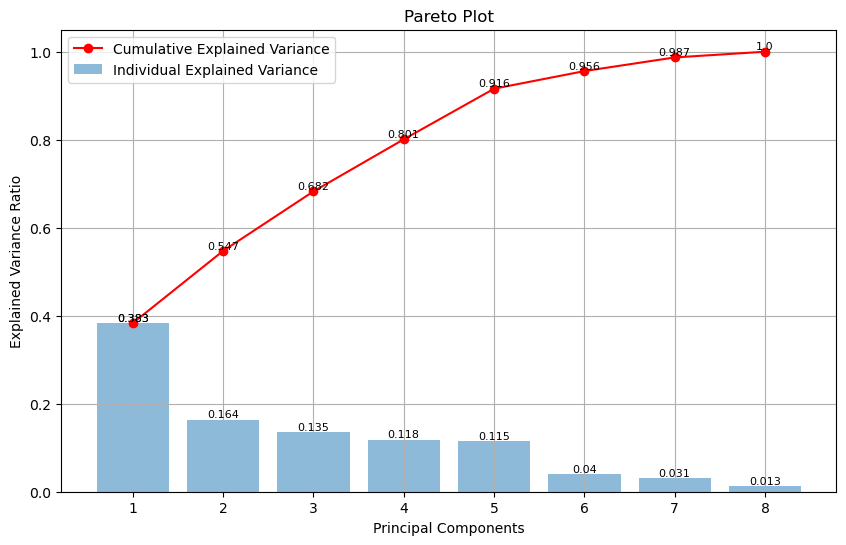

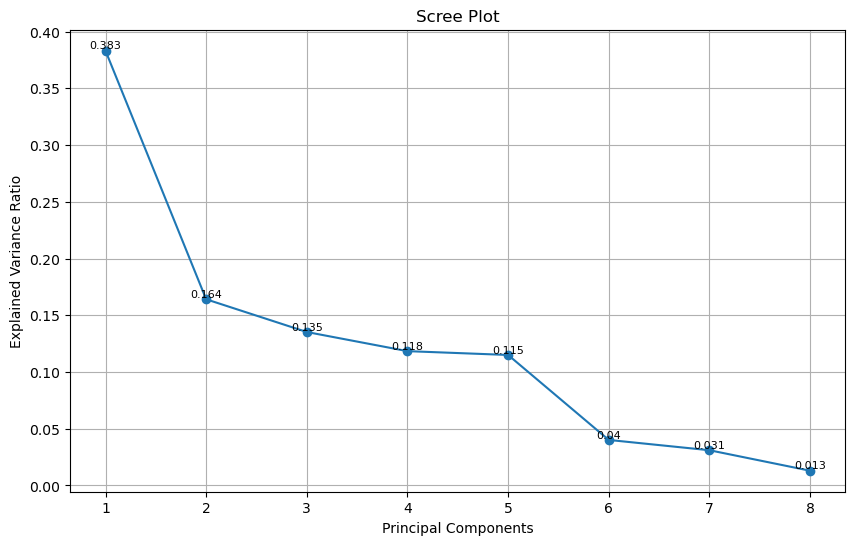

In [18]:
columns = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum']

df = pd.read_csv("palo_alto_data_with_zero.csv")
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)

pca = GetPcaTransformedData()
pca_transformed_data = pca.transform_data(df, columns)
df = np.array(pca_transformed_data)

train_ratio = 0.70
batch_size = 256

data_train, data_test, ground_truth_train, ground_truth_test = PrepareDataForInput(parameters_seq2seq).get_train_test_dataset_forecasting(df, train_ratio)

step_per_epoch = len(data_train) // batch_size

# Converting to tensor
data_train = torch.from_numpy(data_train).float().to(device)
ground_truth_train = torch.from_numpy(ground_truth_train).float().to(device)

In [19]:
#  L  S  T  M    T  R  A  I  N 

model = vanilla_LSTM(parameters_lstm).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = parameters_lstm.learning_rate, weight_decay = 0.005)
loss_function_lstm = nn.MSELoss()

In [20]:
wrapper = ModelWrapper(model_parameter=parameters_lstm, col=5)

In [21]:
real_dataset_lstm, gen_dataset_lstm, errors_generator_lstm = wrapper.train_model(model, optimizer, loss_function_lstm, data_train, ground_truth_train, step_per_epoch)

epoch: 0, Train loss: 76.6097291
epoch: 1, Train loss: 70.7944745
epoch: 2, Train loss: 72.3269533
epoch: 3, Train loss: 71.3739528
epoch: 4, Train loss: 71.1315188
epoch: 5, Train loss: 70.9691898
epoch: 6, Train loss: 70.7943407
epoch: 7, Train loss: 70.5619795
epoch: 8, Train loss: 70.2224952
epoch: 9, Train loss: 69.7057798
epoch: 10, Train loss: 68.9186993
epoch: 11, Train loss: 67.7567691
epoch: 12, Train loss: 62.7615970
epoch: 13, Train loss: 60.1215704
epoch: 14, Train loss: 57.1131338
epoch: 15, Train loss: 54.1300876
epoch: 16, Train loss: 51.7083361
epoch: 17, Train loss: 49.9569788
epoch: 18, Train loss: 48.7346324
epoch: 19, Train loss: 47.8679323
epoch: 20, Train loss: 47.2396808
epoch: 21, Train loss: 46.7624837
epoch: 22, Train loss: 46.3836260
epoch: 23, Train loss: 46.0721591
epoch: 24, Train loss: 45.8055873
epoch: 25, Train loss: 45.5690607
epoch: 26, Train loss: 45.3528668
epoch: 27, Train loss: 45.1508620
epoch: 28, Train loss: 44.9501389
epoch: 29, Train loss: 3

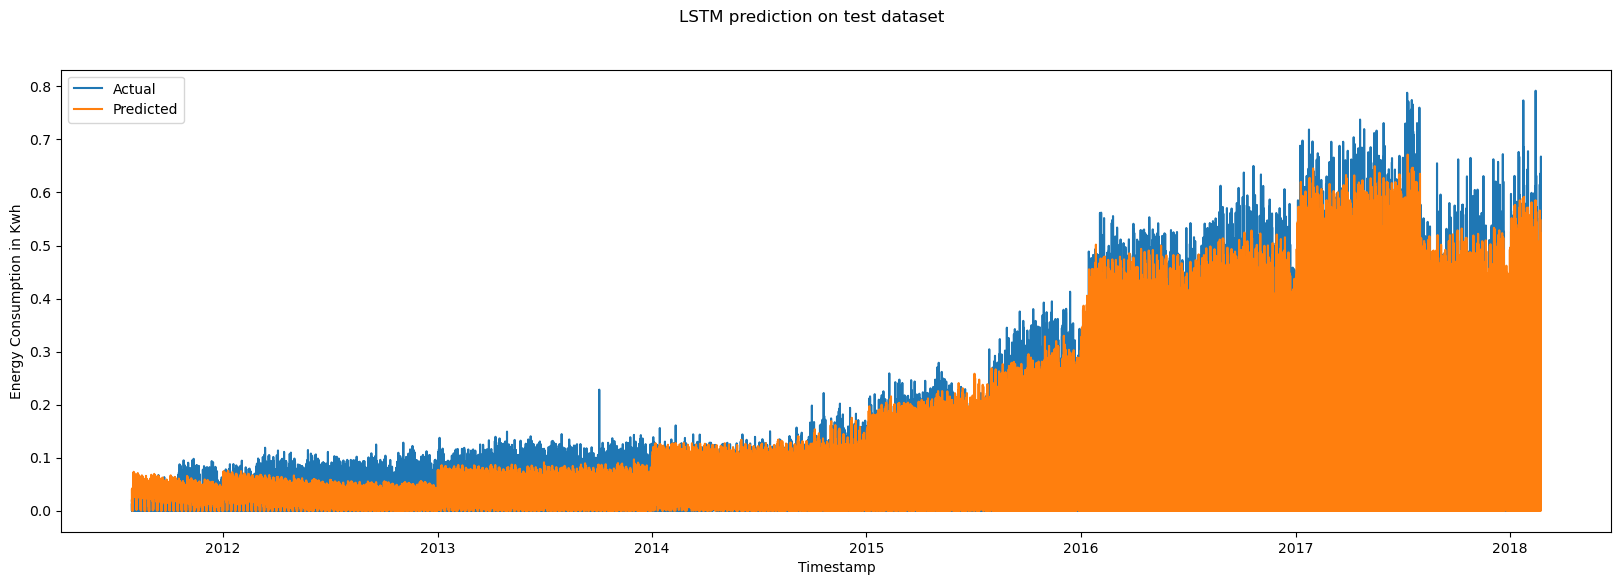

In [49]:
plot_full_dataset(real_dataset_lstm[:, -1, :].detach().cpu().numpy(), gen_dataset_lstm[:, -1, :].detach().cpu().numpy(),timestamps, 000, 57600, 5, 'LSTM')

In [23]:
#  L  S  T  M    T  E  S  T

data_test = data_test[: -(data_test.shape[0] % parameters_lstm.batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % parameters_lstm.batch_size)]

In [24]:
step_per_epoch = len(data_test) // parameters_lstm.batch_size

In [25]:
data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [26]:
real_data_lstm, predicted_data_lstm, loss_lstm, smape_loss, mae_loss, mse_loss, rmse_loss, r2_loss = wrapper.test_model(model, data_test, ground_truth_test, loss_function_lstm, step_per_epoch)

RMSE:  0.14092338263678053
MAE:  0.1075991013397773


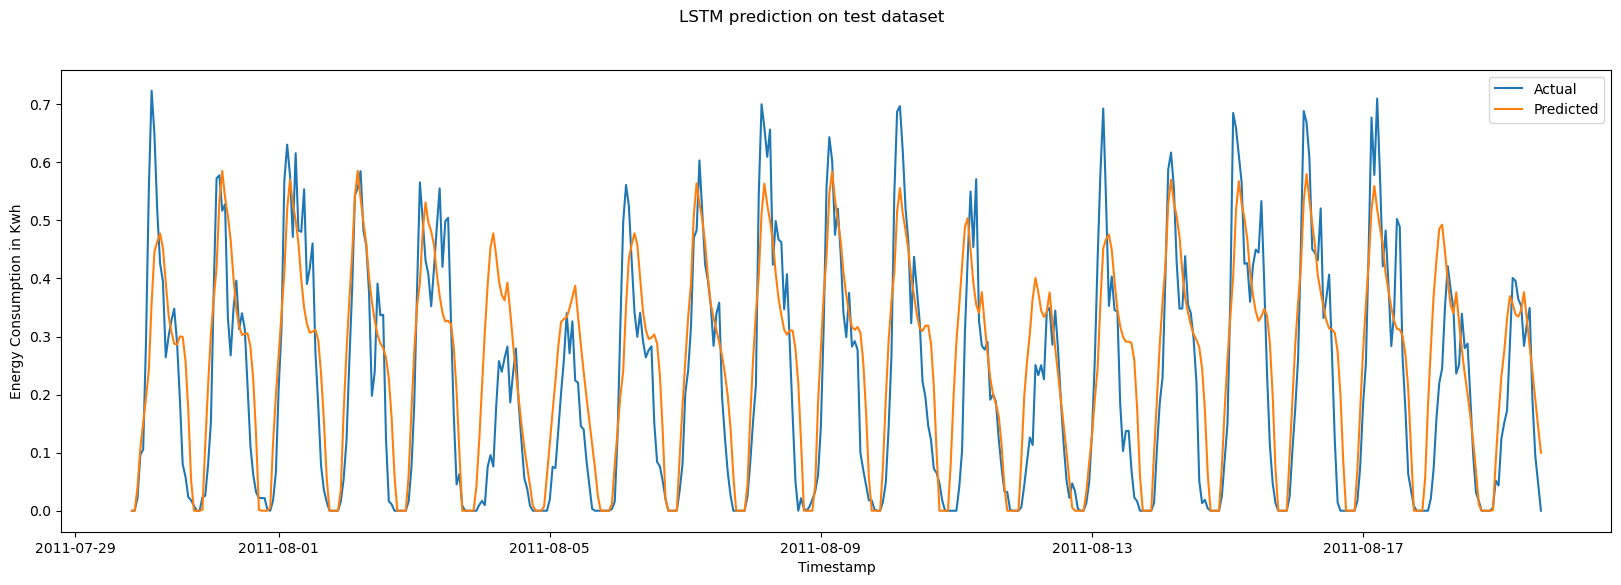

In [27]:
plot_full_dataset(real_data_lstm[:, -1, :].detach().cpu().numpy(), predicted_data_lstm[:, -1, :].detach().cpu().numpy(),timestamps, 000, 500, 5, 'LSTM')

[0.28689099 0.12285223 0.10125487 0.08863008 0.08610584]
[[ 5.61769866e-01 -4.99721256e-02 -8.23238530e-01 -1.24509091e-02
   4.20043559e-03 -8.62077683e-04 -1.47596385e-02 -6.16803733e-02]
 [ 4.08763346e-02  2.86563689e-01 -4.28852827e-02  5.23840794e-01
  -2.58619698e-01 -1.40526443e-02  6.14144171e-01  4.42388250e-01]
 [-5.80121604e-03 -1.08638062e-02  7.47711321e-03  3.13915250e-01
  -7.95510321e-01 -5.10220857e-02 -4.95608317e-01 -1.42063733e-01]
 [-3.35318085e-03 -1.03254358e-01  3.55958618e-03 -7.14340439e-01
  -5.35663813e-01 -1.28775559e-01  4.18676897e-01  1.49382484e-02]
 [ 3.77913572e-04 -1.14580670e-02 -2.71867046e-04 -6.84427879e-02
  -1.14353604e-01  9.90256966e-01  3.87034649e-02 -7.19706249e-04]]


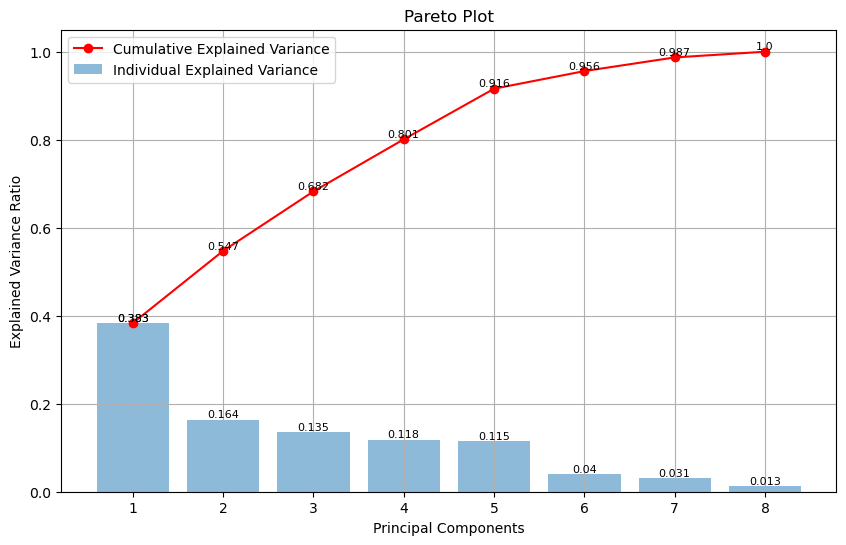

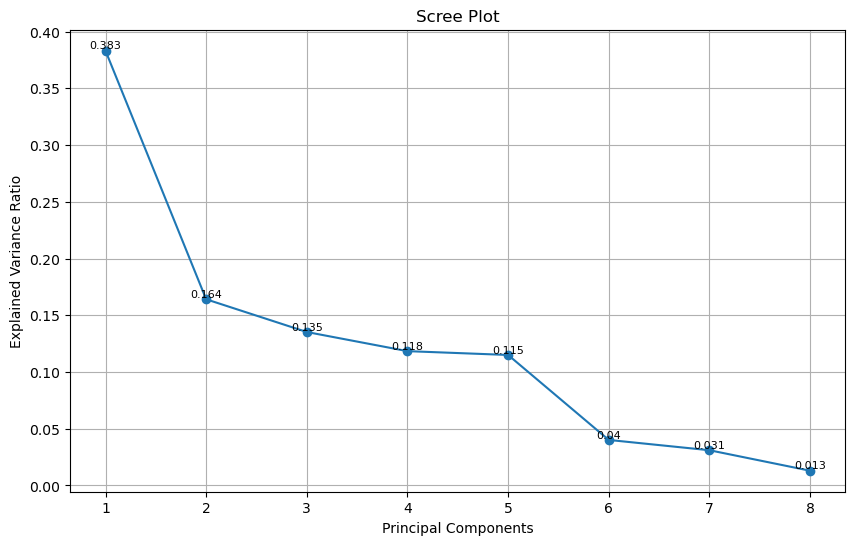

In [28]:
columns = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum']

df = pd.read_csv("palo_alto_data_with_zero.csv")
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)

pca = GetPcaTransformedData()
pca_transformed_data = pca.transform_data(df, columns)
df = np.array(pca_transformed_data)

train_ratio = 0.70

data_train, data_test, ground_truth_train, ground_truth_test = PrepareDataForInput(parameters_seq2seq).get_train_test_dataset_forecasting(df, train_ratio)

step_per_epoch = len(data_train) // batch_size

# Converting to tensor
data_train = torch.from_numpy(data_train).float().to(device)
ground_truth_train = torch.from_numpy(ground_truth_train).float().to(device)

In [29]:
#  B i  L  S  T  M     T  R  A  I  N

model = Bi_LSTM(parameters_bilstm).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = parameters_bilstm.learning_rate, weight_decay = 0.005)
loss_function_bilstm = nn.MSELoss()

In [30]:
wrapper = ModelWrapper(model_parameter=parameters_bilstm, col=5)

In [31]:
real_dataset_bilstm, gen_dataset_bilstm, errors_generator_bilstm = wrapper.train_model(model, optimizer, loss_function_bilstm, data_train, ground_truth_train, step_per_epoch)

epoch: 0, Train loss: 46.2713387
epoch: 1, Train loss: 61.7327905
epoch: 2, Train loss: 54.5673515
epoch: 3, Train loss: 50.4870250
epoch: 4, Train loss: 46.4050673
epoch: 5, Train loss: 41.1441374
epoch: 6, Train loss: 33.1141657
epoch: 7, Train loss: 29.7413152
epoch: 8, Train loss: 26.9292417
epoch: 9, Train loss: 24.9264558
epoch: 10, Train loss: 23.4856852
epoch: 11, Train loss: 22.4228135
epoch: 12, Train loss: 21.6271588
epoch: 13, Train loss: 20.9991447
epoch: 14, Train loss: 20.4856657
epoch: 15, Train loss: 20.0559720
epoch: 16, Train loss: 19.6887049
epoch: 17, Train loss: 19.3691860
epoch: 18, Train loss: 19.0869862
epoch: 19, Train loss: 18.8348435
epoch: 20, Train loss: 18.6059078
epoch: 21, Train loss: 18.3954317
epoch: 22, Train loss: 18.1992721
epoch: 23, Train loss: 18.0155064
epoch: 24, Train loss: 17.8417072
epoch: 25, Train loss: 17.6742138
epoch: 26, Train loss: 17.5110864
epoch: 27, Train loss: 17.3525848
epoch: 28, Train loss: 17.1963475
epoch: 29, Train loss: 1

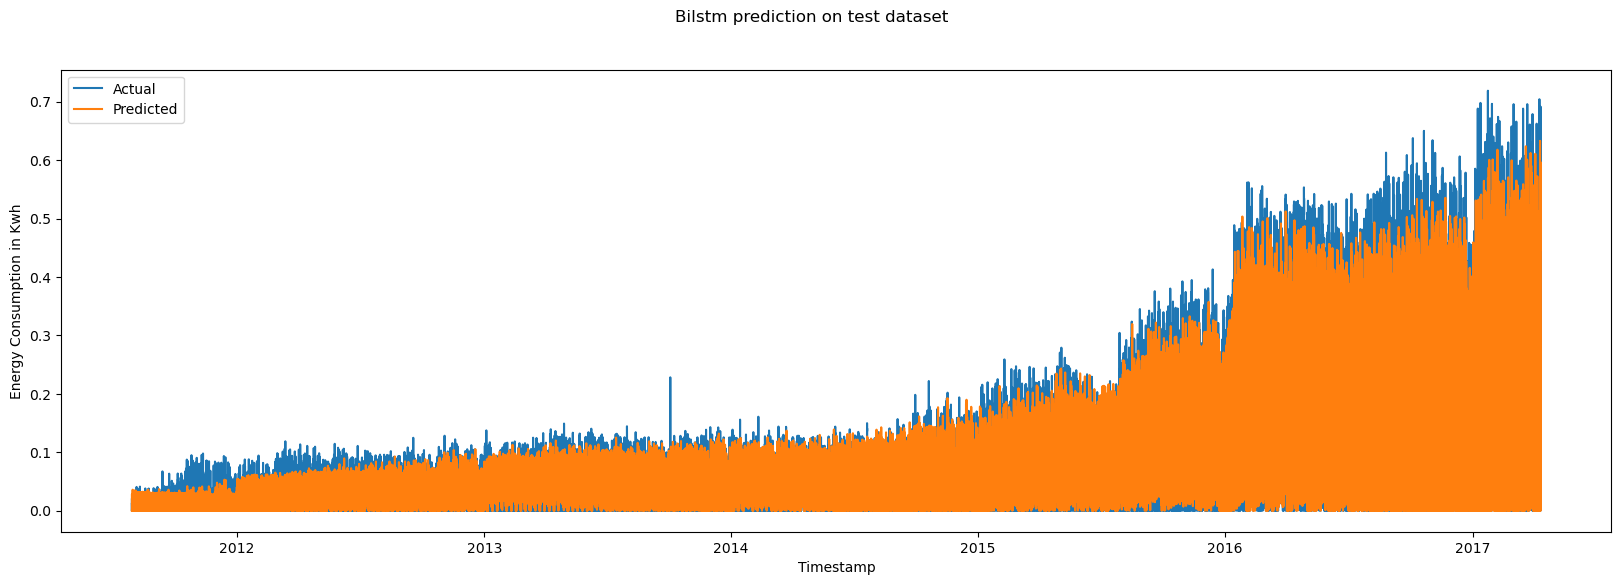

In [32]:
plot_full_dataset(real_dataset_bilstm[:, -1, :].detach().cpu().numpy(), gen_dataset_bilstm[:, -1, :].detach().cpu().numpy(), timestamps, 000, 50000, 5, 'Bilstm')

In [33]:
#  B i  L  S  T  M    T  E  S  T

data_test = data_test[: -(data_test.shape[0] % parameters_bilstm.batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % parameters_bilstm.batch_size)]

step_per_epoch = len(data_test) // parameters_bilstm.batch_size

data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [34]:
real_data_bilstm, predicted_data_bilstm, loss_bilstm, smape_loss, mae_loss, mse_loss, rmse_loss, r2_loss = wrapper.test_model(model, data_test, ground_truth_test, loss_function_bilstm, step_per_epoch)

RMSE:  0.1215445314689229
MAE:  0.08274545376965155


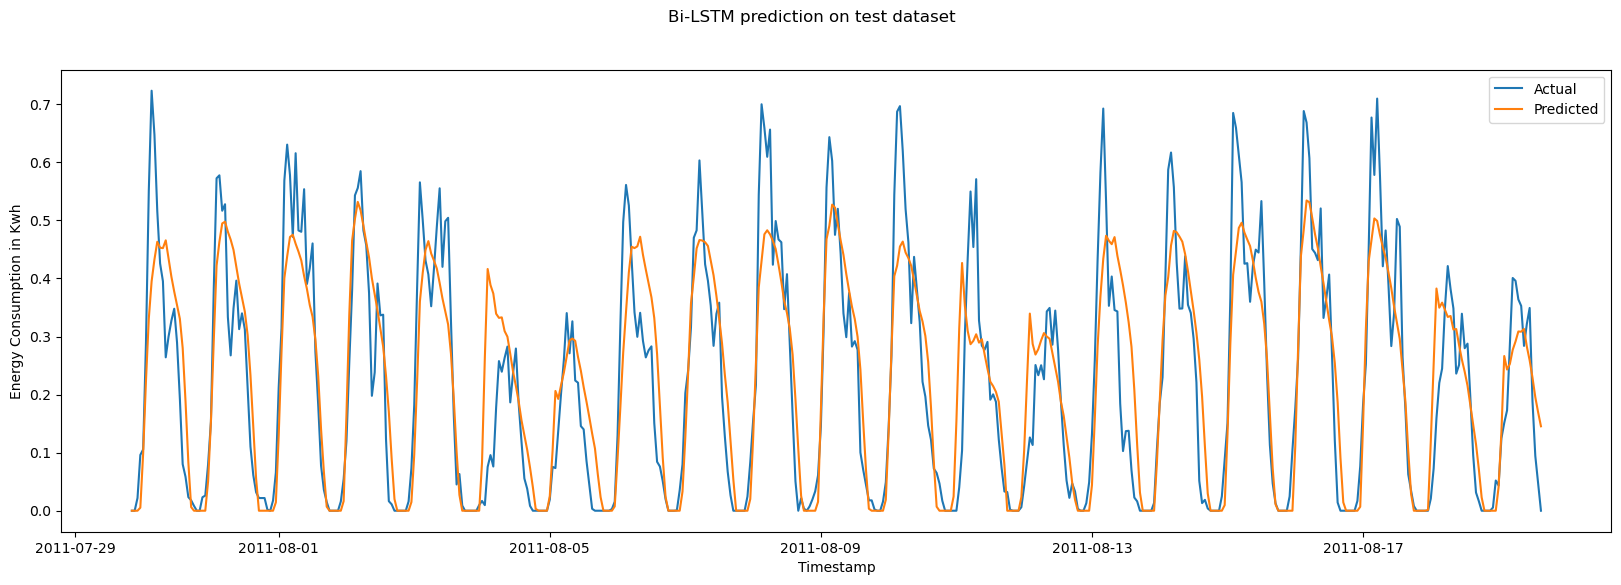

In [35]:
plot_full_dataset(real_data_bilstm[:, -1, :].detach().cpu().numpy(), predicted_data_bilstm[:, -1, :].detach().cpu().numpy(), timestamps, 000, 500, 5, 'Bi-LSTM')

[0.28689099 0.12285223 0.10125487 0.08863008 0.08610584]
[[ 5.61769866e-01 -4.99721256e-02 -8.23238530e-01 -1.24509091e-02
   4.20043559e-03 -8.62077683e-04 -1.47596385e-02 -6.16803733e-02]
 [ 4.08763346e-02  2.86563689e-01 -4.28852827e-02  5.23840794e-01
  -2.58619698e-01 -1.40526443e-02  6.14144171e-01  4.42388250e-01]
 [-5.80121604e-03 -1.08638062e-02  7.47711321e-03  3.13915250e-01
  -7.95510321e-01 -5.10220857e-02 -4.95608317e-01 -1.42063733e-01]
 [-3.35318085e-03 -1.03254358e-01  3.55958618e-03 -7.14340439e-01
  -5.35663813e-01 -1.28775559e-01  4.18676897e-01  1.49382484e-02]
 [ 3.77913572e-04 -1.14580670e-02 -2.71867046e-04 -6.84427879e-02
  -1.14353604e-01  9.90256966e-01  3.87034649e-02 -7.19706249e-04]]


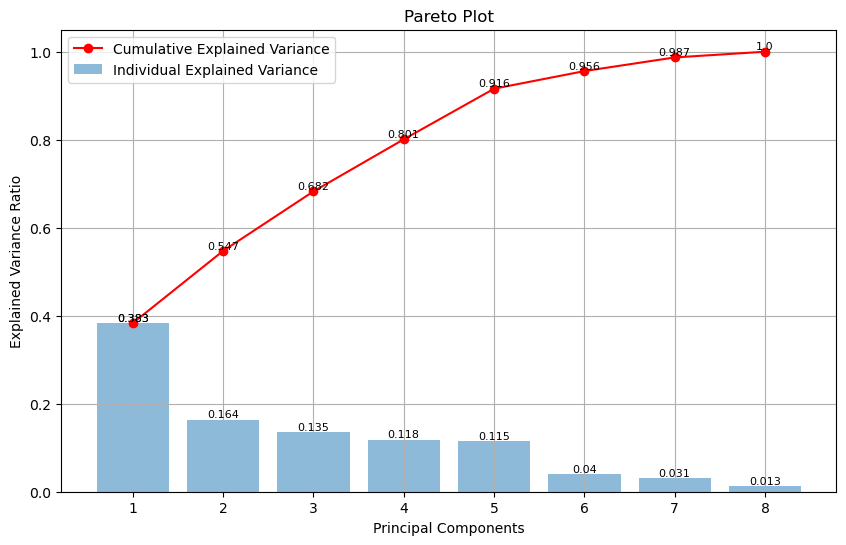

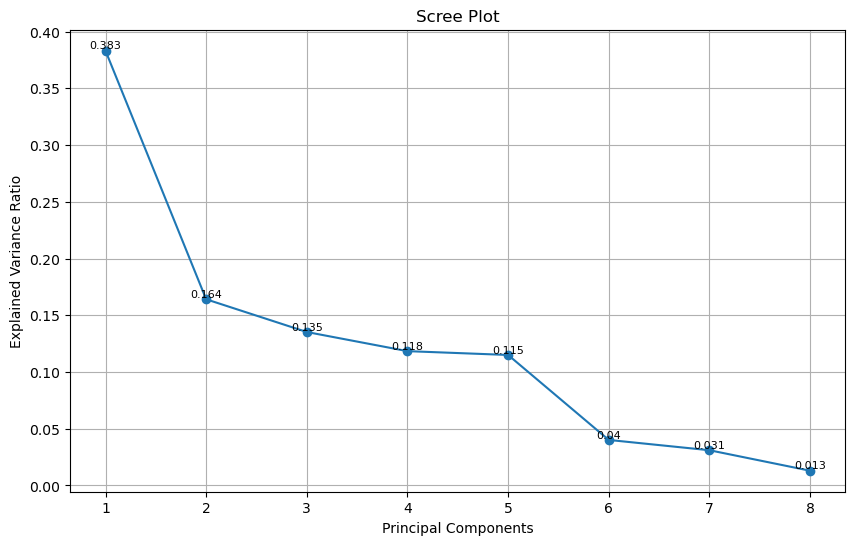

In [36]:
columns = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum']

df = pd.read_csv("palo_alto_data_with_zero.csv")
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)

pca = GetPcaTransformedData()
pca_transformed_data = pca.transform_data(df, columns)
df = np.array(pca_transformed_data)

train_ratio = 0.70

data_train, data_test, ground_truth_train, ground_truth_test = PrepareDataForInput(parameters_seq2seq).get_train_test_dataset_forecasting(df, train_ratio)

step_per_epoch = len(data_train) // batch_size

# Converting to tensor
data_train = torch.from_numpy(data_train).float().to(device)
ground_truth_train = torch.from_numpy(ground_truth_train).float().to(device)

In [37]:
# S  E  Q .2. S  E  Q    T  R  A  I  N

model = Seq2SeqConv1D(parameters_seq2seq).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = parameters_seq2seq.learning_rate, weight_decay = 0.005)
loss_function_seq = nn.MSELoss()

In [38]:
wrapper = ModelWrapper(model_parameter=parameters_seq2seq, col=5)

In [39]:
real_dataset_seq, gen_dataset_seq, errors_generator_seq = wrapper.train_model(model, optimizer, loss_function_seq, data_train, ground_truth_train, step_per_epoch)

epoch: 0, Train loss: 81.5492156
epoch: 1, Train loss: 50.5734680
epoch: 2, Train loss: 41.6275490
epoch: 3, Train loss: 37.0011124
epoch: 4, Train loss: 34.0604011
epoch: 5, Train loss: 32.0438498
epoch: 6, Train loss: 30.6042704
epoch: 7, Train loss: 29.4844801
epoch: 8, Train loss: 21.2205465
epoch: 9, Train loss: 20.0156259
epoch: 10, Train loss: 19.4535721
epoch: 11, Train loss: 18.9446031
epoch: 12, Train loss: 18.4876759
epoch: 13, Train loss: 18.1220436
epoch: 14, Train loss: 17.8366044
epoch: 15, Train loss: 17.5409690
epoch: 16, Train loss: 17.3337906
epoch: 17, Train loss: 17.1467150
epoch: 18, Train loss: 16.9900878
epoch: 19, Train loss: 16.8245401
epoch: 20, Train loss: 16.6829117
epoch: 21, Train loss: 16.5726925
epoch: 22, Train loss: 10.6558266
epoch: 23, Train loss: 9.8151233
epoch: 24, Train loss: 8.5137351
epoch: 25, Train loss: 8.1440401
epoch: 26, Train loss: 7.9413787
epoch: 27, Train loss: 7.8122047
epoch: 28, Train loss: 7.6766446
epoch: 29, Train loss: 7.56646

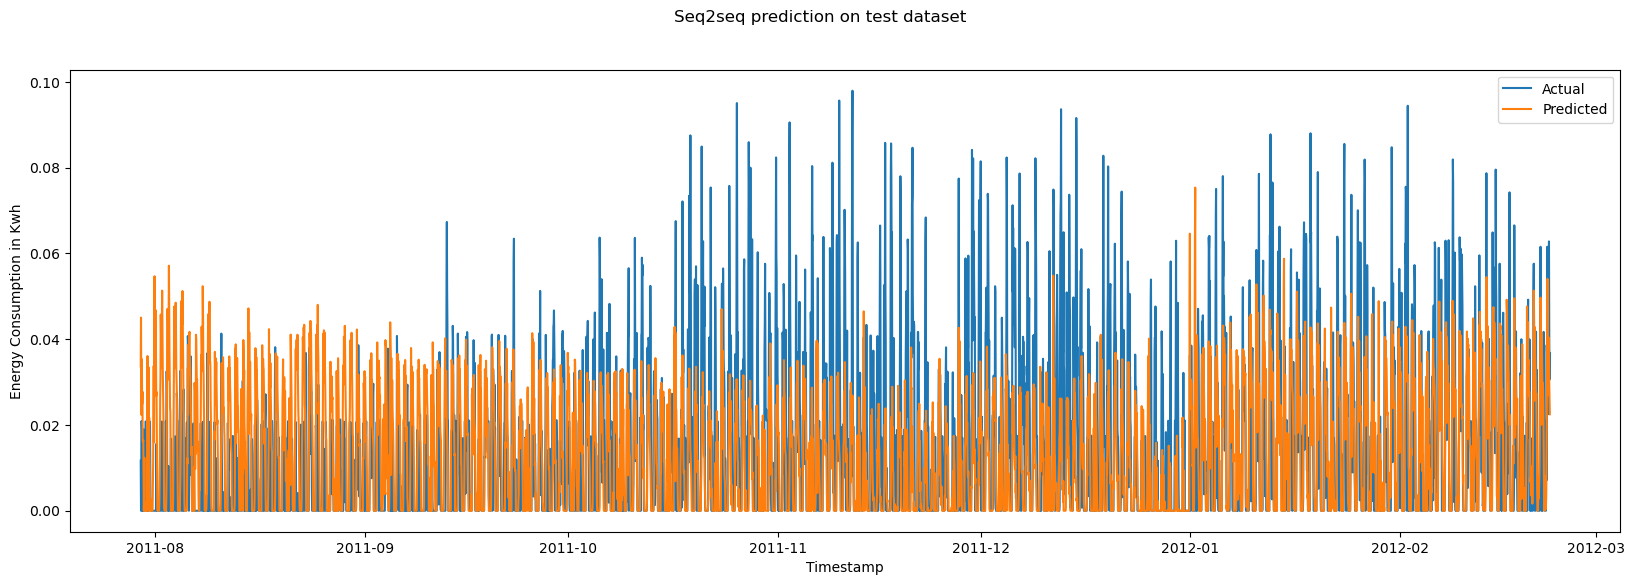

In [40]:
plot_full_dataset(real_dataset_seq[:, -1, :].detach().cpu().numpy(), gen_dataset_seq[:, -1, :].detach().cpu().numpy(), timestamps, 000, 5000, 5, 'Seq2seq')

In [41]:
# S  E  Q .2. S  E  Q    T  E  S  T

data_test = data_test[: -(data_test.shape[0] % parameters_seq2seq.batch_size)]
ground_truth_test = ground_truth_test[: -(ground_truth_test.shape[0] % parameters_seq2seq.batch_size)]

step_per_epoch = len(data_test) // parameters_seq2seq.batch_size

data_test = torch.from_numpy(data_test).float().to(device)
ground_truth_test = torch.from_numpy(ground_truth_test).float().to(device)

In [42]:
real_data_seq, predicted_data_seq, loss_seq, smape_loss, mae_loss, mse_loss, rmse_loss, r2_loss = wrapper.test_model(model, data_test, ground_truth_test, loss_function_seq, step_per_epoch)

RMSE:  0.12724414778252444
MAE:  0.09169129169701289


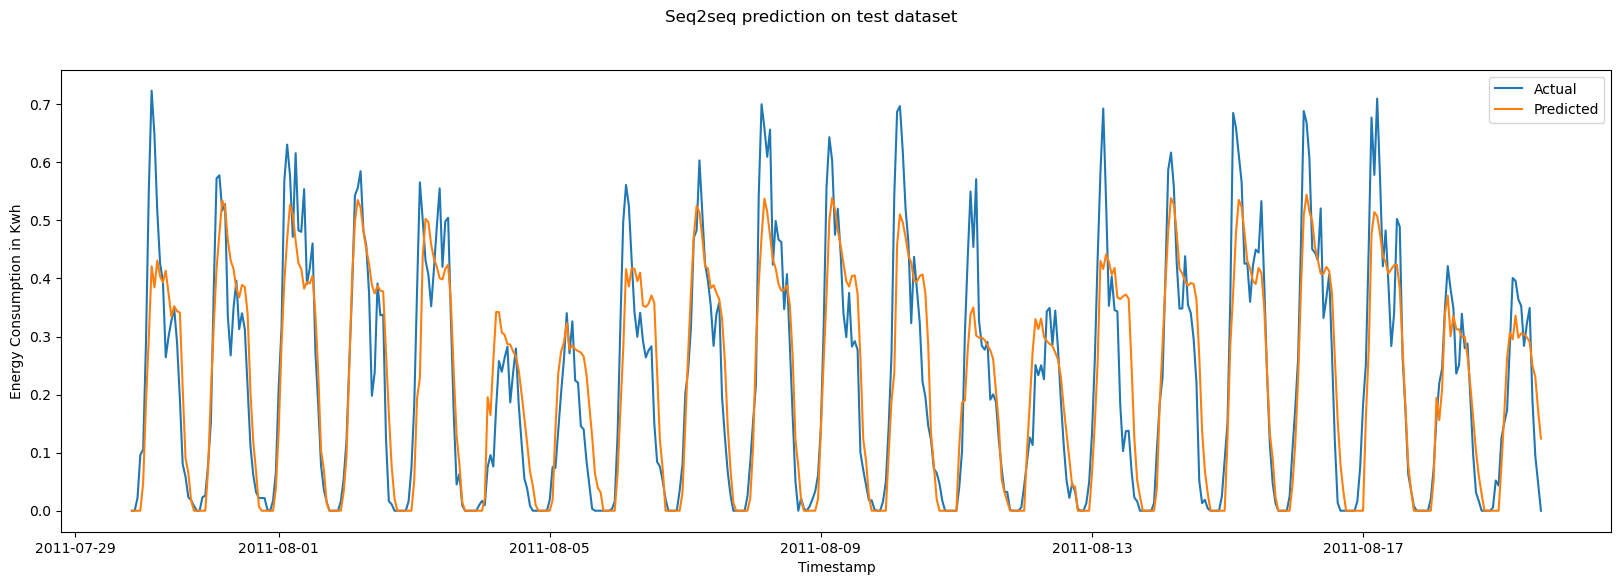

In [43]:
plot_full_dataset(real_data_seq[:, -1, :].detach().cpu().numpy(), predicted_data_seq[:, -1, :].detach().cpu().numpy(),timestamps, 000, 500, 5, 'Seq2seq')

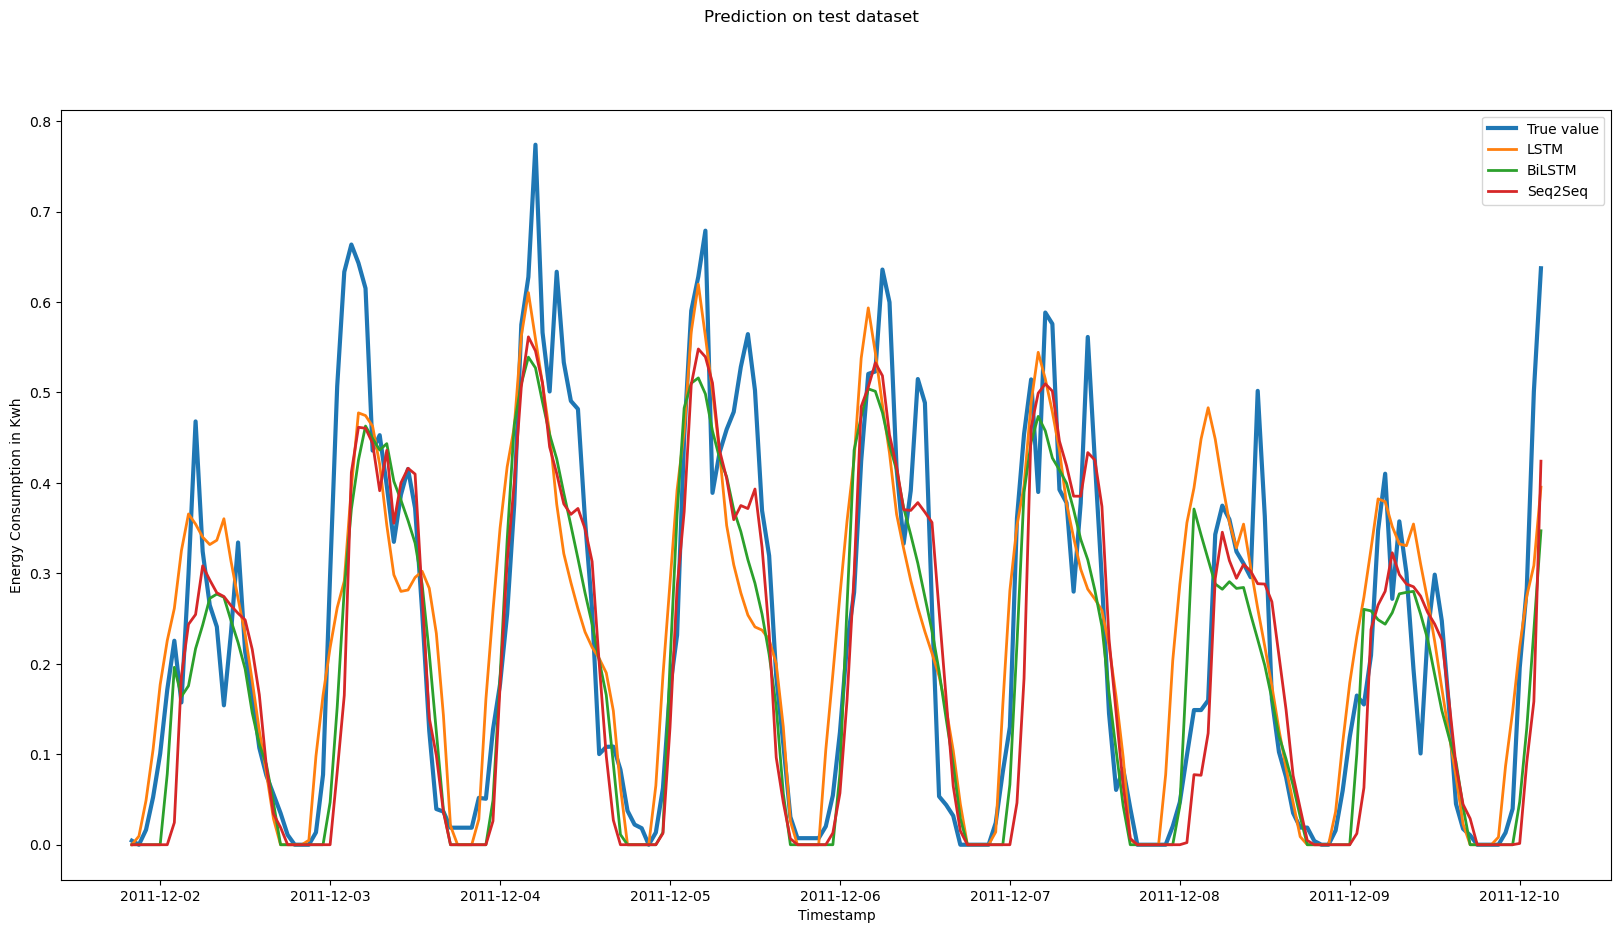

In [44]:
compare_predicted_dataset(real_data_seq[:, -1, :].detach().cpu().numpy(), predicted_data_lstm[:, -1, :].detach().cpu().numpy(), predicted_data_bilstm[:, -1, :].detach().cpu().numpy(), predicted_data_seq[:, -1, :].detach().cpu().numpy(), timestamps, 3000, 3200, 5)